In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.model_selection import KFold
import collections
from sklearn import metrics
from decimal import ROUND_DOWN
from sqlite3 import Row
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
df = df.set_index('ID')
test = pd.read_csv('test.csv')
test = test.set_index('ID')

# 1.觀察&清洗資料

## 1.1確認屬性:觀察資料train與test型態是否有一致

In [3]:
#Before 有發現train.csv與test.csv相同欄位出現形態不同的現象發生
print(df.info())
print(test.info())

#解決方法：將型態一致
df = df.astype('float')
test = test.astype('float')

#確認是否更改成功
print(df.info())
print(test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8100 entries, 8773 to 552
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           8100 non-null   int64  
 1   Administrative_Duration  8100 non-null   float64
 2   Informational            8100 non-null   int64  
 3   Informational_Duration   8100 non-null   float64
 4   ProductRelated           8100 non-null   int64  
 5   ProductRelated_Duration  8099 non-null   float64
 6   BounceRates              8100 non-null   float64
 7   ExitRates                8100 non-null   float64
 8   PageValues               8100 non-null   float64
 9   SpecialDay               8100 non-null   float64
 10  Month                    8100 non-null   int64  
 11  OperatingSystems         8099 non-null   float64
 12  Browser                  8099 non-null   float64
 13  Region                   8099 non-null   float64
 14  TrafficType           

## 1.2觀察缺失值數量、比例．使用眾數填補缺失值

VisitorType                1
TrafficType                1
ProductRelated_Duration    1
Region                     1
Browser                    1
OperatingSystems           1
Administrative             0
Month                      0
Weekend                    0
SpecialDay                 0
Administrative_Duration    0
PageValues                 0
ExitRates                  0
BounceRates                0
ProductRelated             0
Informational_Duration     0
Informational              0
Revenue                    0
dtype: int64
VisitorType                0.000123
TrafficType                0.000123
ProductRelated_Duration    0.000123
Region                     0.000123
Browser                    0.000123
OperatingSystems           0.000123
Administrative             0.000000
Month                      0.000000
Weekend                    0.000000
SpecialDay                 0.000000
Administrative_Duration    0.000000
PageValues                 0.000000
ExitRates                  0.0000

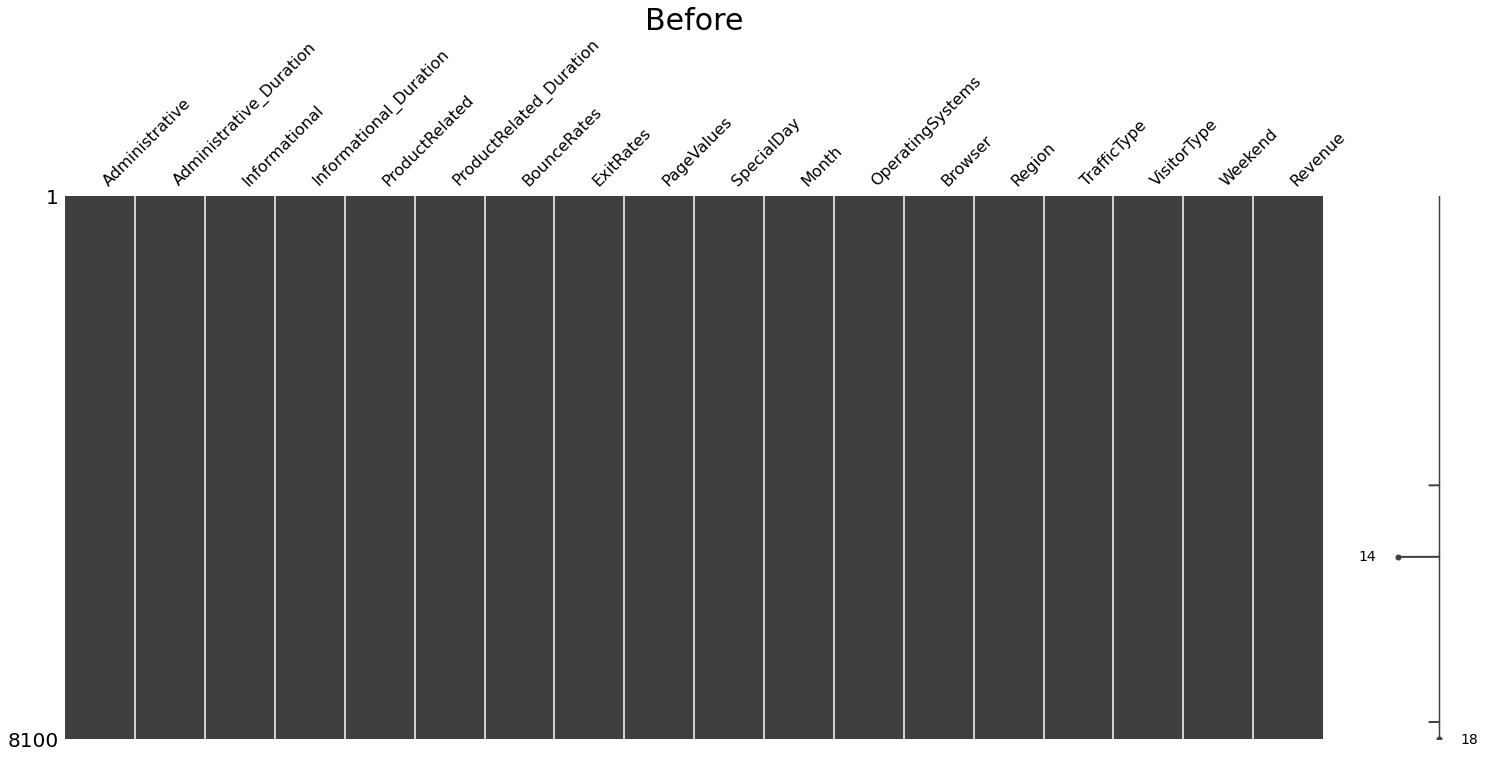

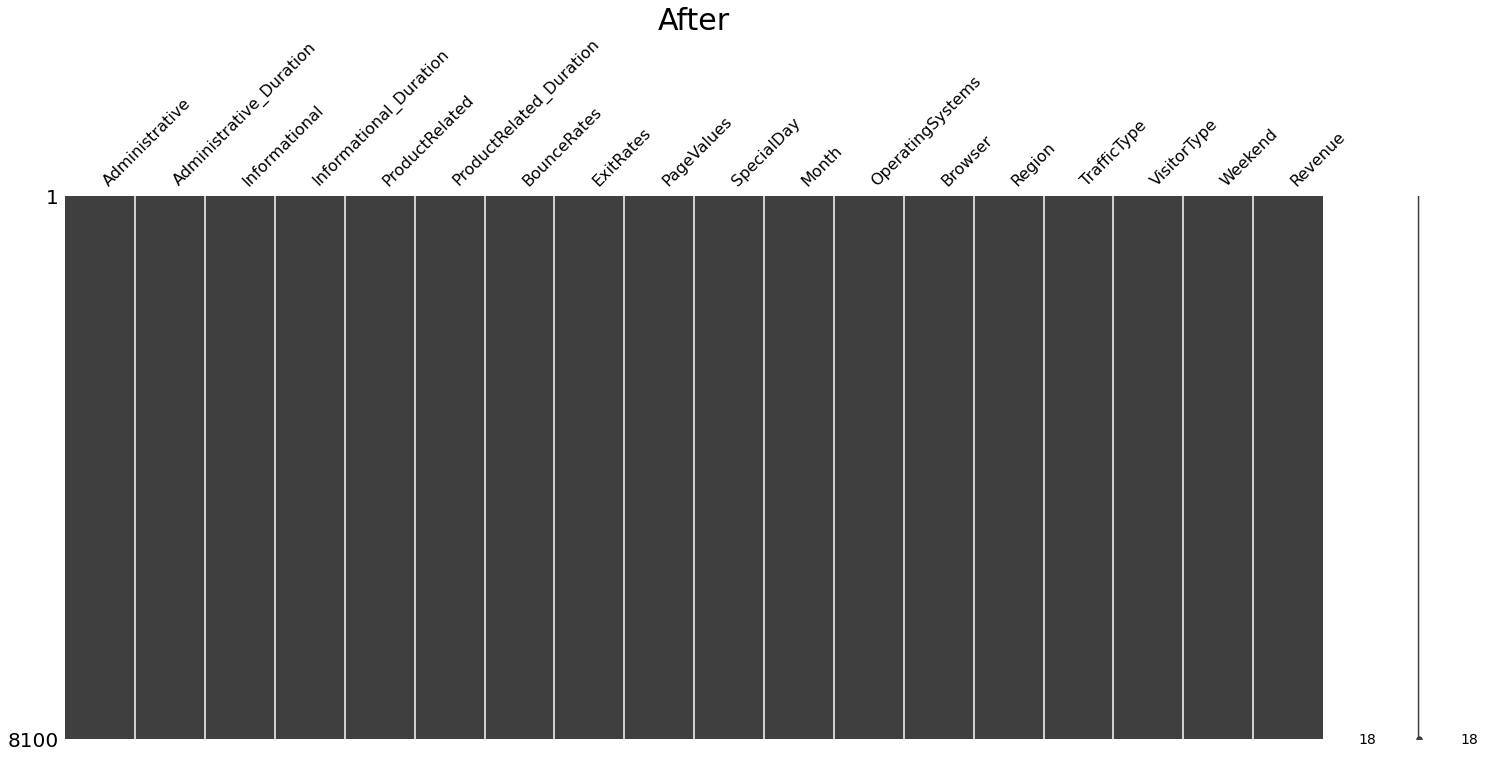

In [4]:
#查看各欄位缺失值數量以及比例
num_vars = df.columns
print(df[num_vars].isnull().sum().sort_values(ascending = False)) 
print(df[num_vars].isnull().sum().sort_values(ascending = False)/len(df))


#視覺化呈現缺失值
msno.matrix(df)
plt.title('Before', fontsize=30)
plt.show()

#以眾數的方式進行缺失值補值
df[num_vars] = df[num_vars].fillna(df[num_vars].mode().iloc[0,:])


#視覺化確認是否補值成功
msno.matrix(df)
plt.title('After', fontsize=30)
plt.show()



## 1.3檢查有無不平衡：目標數量分佈約為 84:15，表示數據集不平衡

0.0    6823
1.0    1277
Name: Revenue, dtype: int64


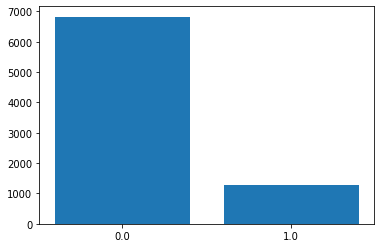

percentage of NO and YES
 0.0    84.234568
1.0    15.765432
Name: Revenue, dtype: float64


In [5]:
print(df['Revenue'].value_counts())
#視覺化呈現目標數量
count_values = pd.DataFrame(df['Revenue'].value_counts())
films = [str(count_values.index[0]), str(count_values.index[1])]    
box_office = [count_values.iloc[0,0], count_values.iloc[1,0]] 
plt.bar(films, box_office)        
plt.show()  
#印出目標數量分佈
print("percentage of NO and YES\n",df["Revenue"].value_counts()/len(df)*100)

## 1.4類別型資料分析：
### 1.4.1 觀察資料特徵是否有定值存在
#### 解決方式：視覺化後無發現定值，且同時發現TrafficType欄位數值種類較多

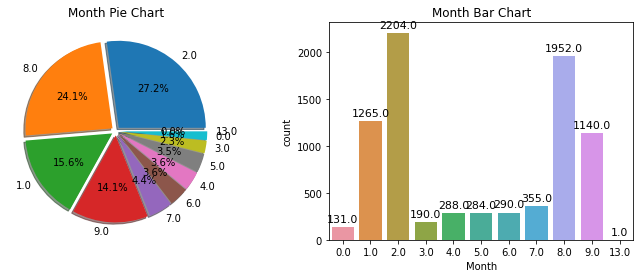

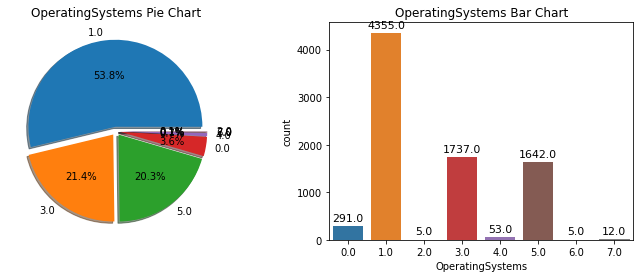

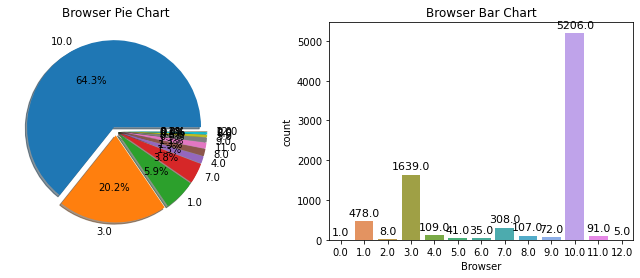

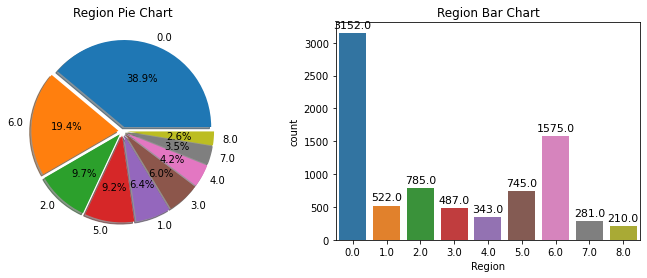

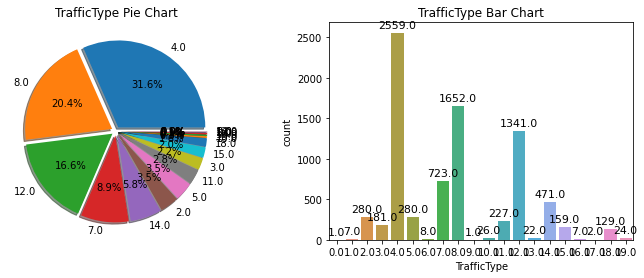

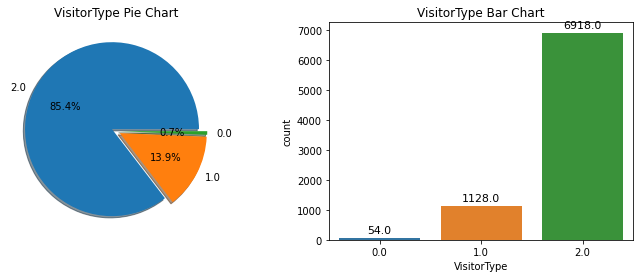

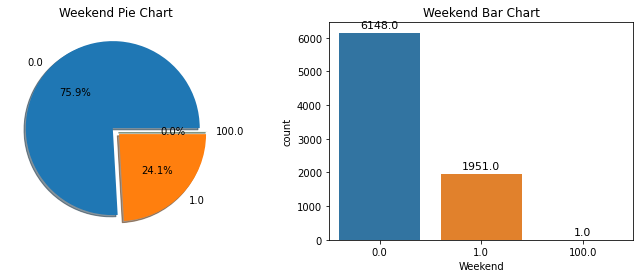

In [6]:
#以下為視覺化類別型資料每個特徵數量，以圓餅圖和長條圖的方式呈現
num = ['Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend']
def cat_plot(data, feature): 
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    #plot Pie plot for a categorical variable
    data[feature].value_counts().plot(kind="pie", explode=[0.05 for x in data[feature].dropna().unique()], autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_title(f"{feature} Pie Chart")
    ax[0].set_ylabel('')
    # Count plot for a categorical variable using bars
    count = sns.countplot(x=feature, data=data, ax=ax[1])
    for bar in count.patches:
        count.annotate(format(bar.get_height()),
            (bar.get_x() + bar.get_width() / 2,
            bar.get_height()), ha='center', va='center',
            size=11, xytext=(0, 8),
            textcoords='offset points')
    ax[1].set_title(f"{feature} Bar Chart")
    plt.show()
for feature in num:
    cat_plot(df,feature)

### 1.4.2 觀察類別資料處理該使用one hot encoding 還是 統計特徵轉換
#### 解決方式：TrafficType視覺化後類別過多，使用one hot encdding 恐會有維度爆炸問題，且該欄位某些種類數量僅有1筆，做one hot encding
#### 效果可能不佳，因此TrafficType欄位改以統計轉換成機率的方式處理

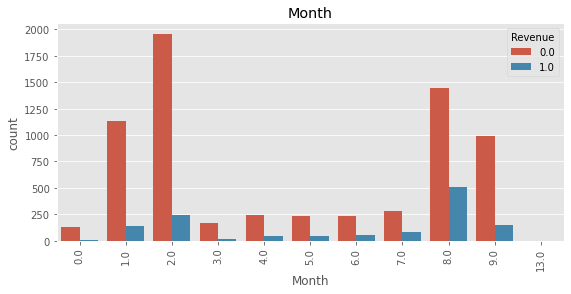

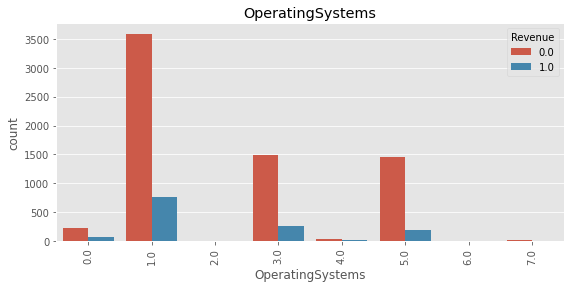

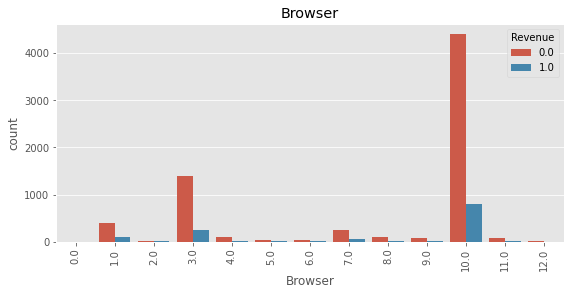

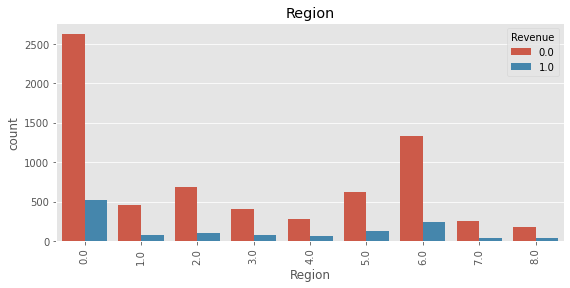

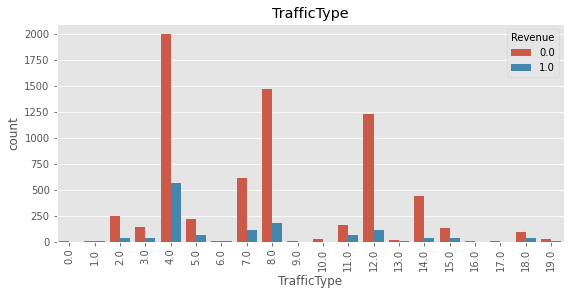

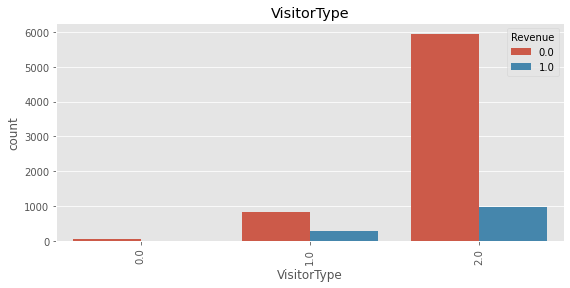

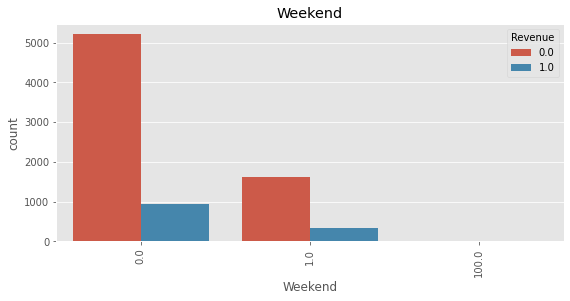

In [7]:
#雙變量視覺化
plt.style.use("ggplot")
y = df['Revenue'].replace({0: 'No', 1: 'Yes'})
for column in num:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.countplot(data=df, x=column, hue="Revenue")
    plt.title(column)    
    plt.xticks(rotation=90)

### 1.4.3 類別型資料清洗
#### 1.4.3.1 將TrafficType轉換成此特徵的訂房率

In [8]:

values = np.unique(df['TrafficType']) #抓出此欄位出現的種類
df['TrafficType_訂房率'] = 0 #初始化新欄位

total_booking = df.groupby(['TrafficType'])['Revenue'].count() #計算每個種類出現次數
yes_booking = df.groupby(['TrafficType'])['Revenue'].sum() #計畫欄位各個種類出現Revenue=1數量
total_booking = total_booking.reset_index()
total_booking = pd.DataFrame(total_booking)
yes_booking = yes_booking.reset_index()
yes_booking = pd.DataFrame(yes_booking)
yes_booking['Percent'] = yes_booking['Revenue'] / total_booking['Revenue'] #計算每個種類Revenue=1/每個總類出現總數
for i in yes_booking['TrafficType']: #將每個種類替換成該種類出現Revenue=1的機率
    df_index = df[df['TrafficType'] == i].index
    df.loc[df_index,'TrafficType_訂房率'] = yes_booking[yes_booking['TrafficType'] == i]['Percent'].values[0]
df = df.drop(columns=['TrafficType'])#刪除欄位



#### 1.4.3.2 其餘類別型資料做one hot encoding

In [9]:
one_hot_columns = ['Month',
       'OperatingSystems', 'Browser', 'Region',  'VisitorType',
       'Weekend']
for i,j in enumerate(one_hot_columns):
       y = pd.get_dummies(df[j], prefix=one_hot_columns[i])
       df = pd.concat([df,y],axis = 1)
       df = df.drop(columns = one_hot_columns[i])


## 1.3統計方法觀察
### 1.3.1 異常值觀察：異常值對平均值和標準差有顯著影響，對於模型學習效果必然也會有影響，有必要對異常值進行處理。

In [10]:
df_describe = df.describe()
df_describe

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Region_5.0,Region_6.0,Region_7.0,Region_8.0,VisitorType_0.0,VisitorType_1.0,VisitorType_2.0,Weekend_0.0,Weekend_1.0,Weekend_100.0
count,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8.100000e+03,8100.000000,8100.000000,8100.000000,8100.000000,...,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000,8100.000000
mean,2.309877,80.926113,0.498025,32.884300,31.787160,8.310522e+04,0.020345,0.042699,5.744406,0.060469,...,0.091975,0.194444,0.034691,0.025926,0.006667,0.139259,0.854074,0.759012,0.240864,0.000123
std,3.311618,180.089694,1.258087,135.210888,44.961092,6.358704e+06,0.131949,0.047943,17.940567,0.197809,...,0.289009,0.395797,0.183008,0.158924,0.081382,0.346238,0.353054,0.427709,0.427634,0.011111
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-11.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,1.836979e+02,0.000000,0.014286,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
50%,1.000000,7.000000,0.000000,0.000000,18.000000,5.988286e+02,0.003203,0.025129,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,4.000000,91.988636,0.000000,0.000000,38.000000,1.461987e+03,0.016925,0.050000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,5.634924e+08,0.200000,0.200000,287.953793,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 數值型資料區分：計量型、計數型
##### 計量型：[Administrative_Duration,Informational_Duration,ProductRelated_Duration,BounceRates,ExitRates,PageValues]
##### 計數型：[Administrative,Informational,ProductRelated]
##### 觀察計量型資料是否具有異常值(計數型資料從上述describe統計中可以看出資料分布較為密集，因此不對計數型資料做異常值處理)

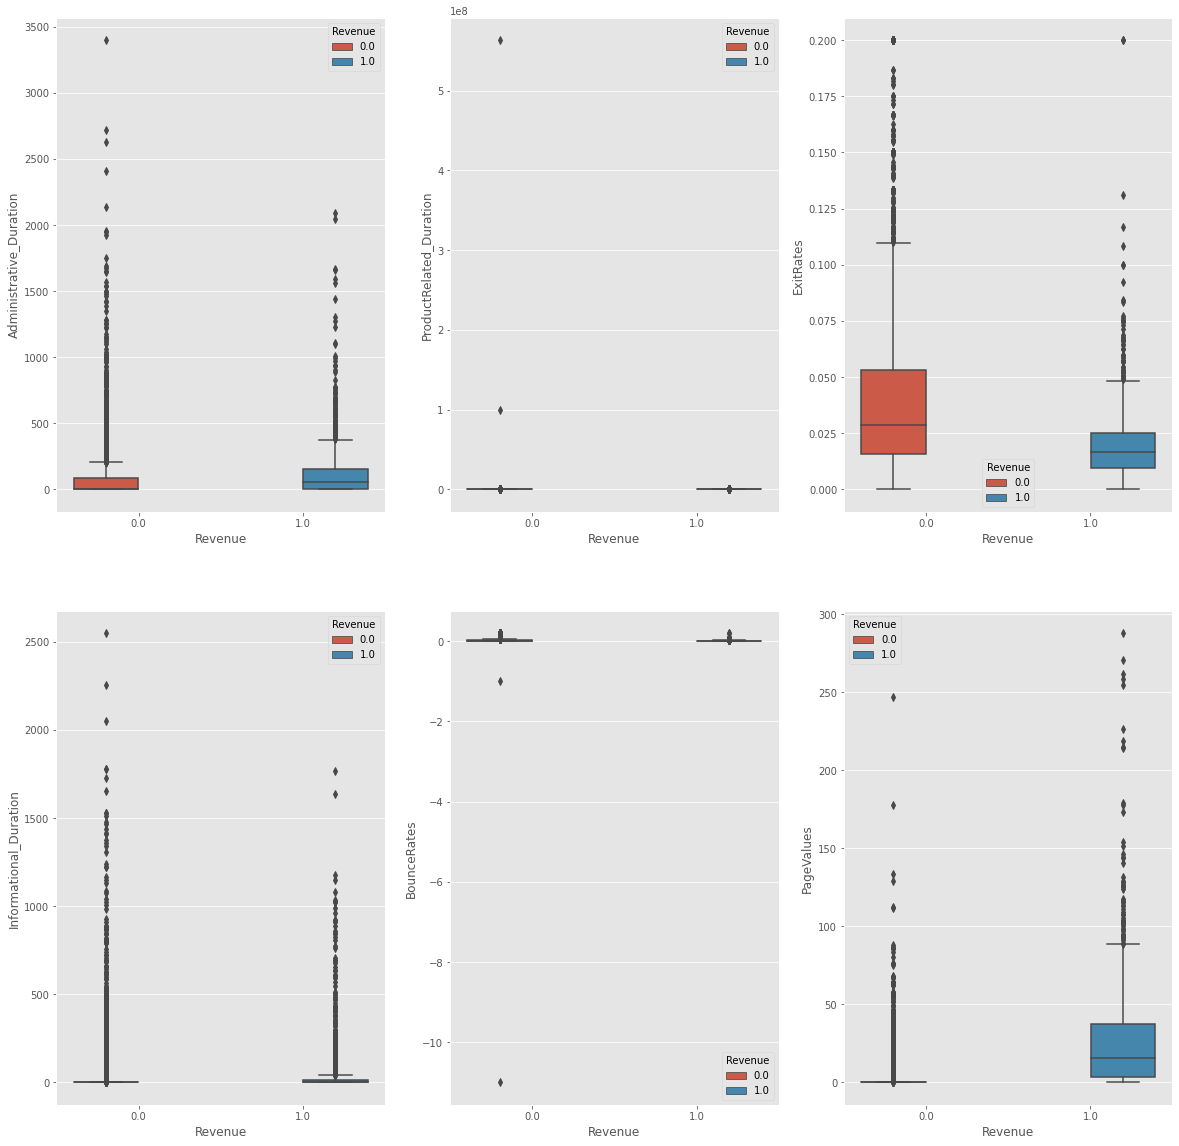

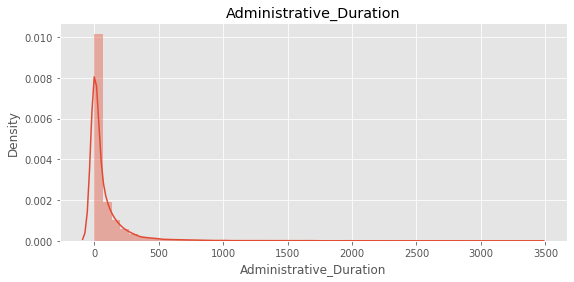

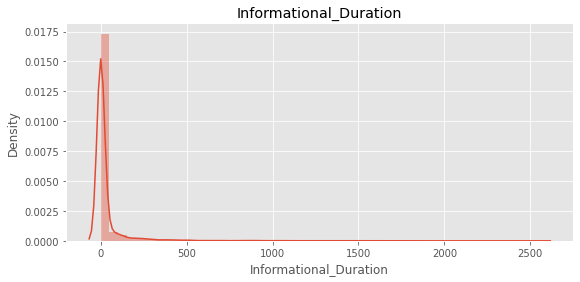

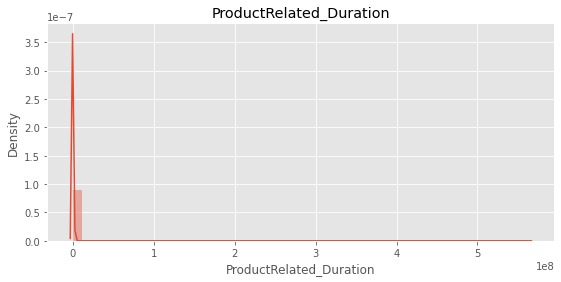

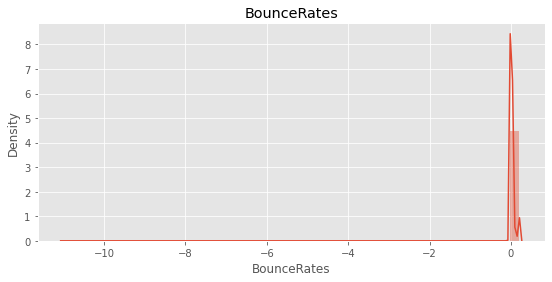

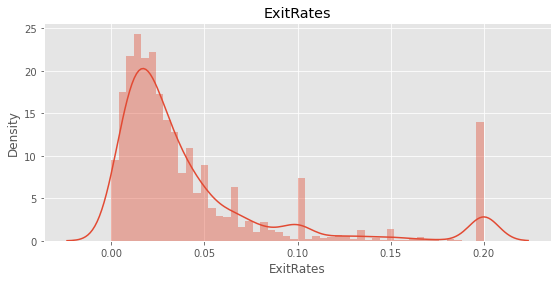

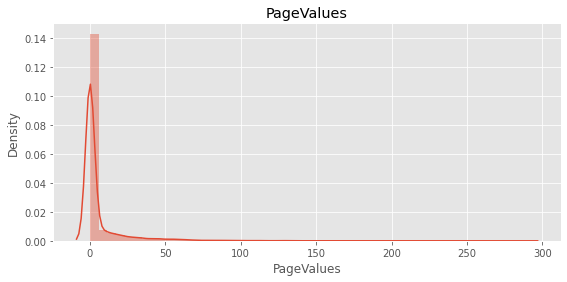

In [11]:
Measurement_col = ['Administrative_Duration','Informational_Duration','ProductRelated_Duration','BounceRates','ExitRates','PageValues']
#箱型圖觀察計量型異常值
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 20))
row_num = 0
wid_num = 0
for i,j in enumerate(Measurement_col):
    if row_num ==2 :
        wid_num  += 1
        row_num = 0
    sns.boxplot(x = 'Revenue' , y = str(j) ,hue = 'Revenue',data = df ,ax = axs[row_num,wid_num])
    row_num += 1

#單變量分析
plt.style.use("ggplot")
for column in Measurement_col:
    plt.figure(figsize=(20,4))
    plt.subplot(121)
    sns.distplot(df[column], kde=True)
    plt.title(column)



### 解決方法：計量型資料異常值，以3倍標準差為界線，若超過3倍標準差，將以mean + 3 *std 取代該異常值

In [12]:
for col in Measurement_col:
    outlier_index = df[df[col] > (df_describe[col]['mean'] + 3 * df_describe[col]['std'])].index #找出異常值index
    df.loc[outlier_index,col] = df_describe[col]['mean'] + 3 * df_describe[col]['std'] #更改異常值數值

### 1.3.2 雙變量資料分析

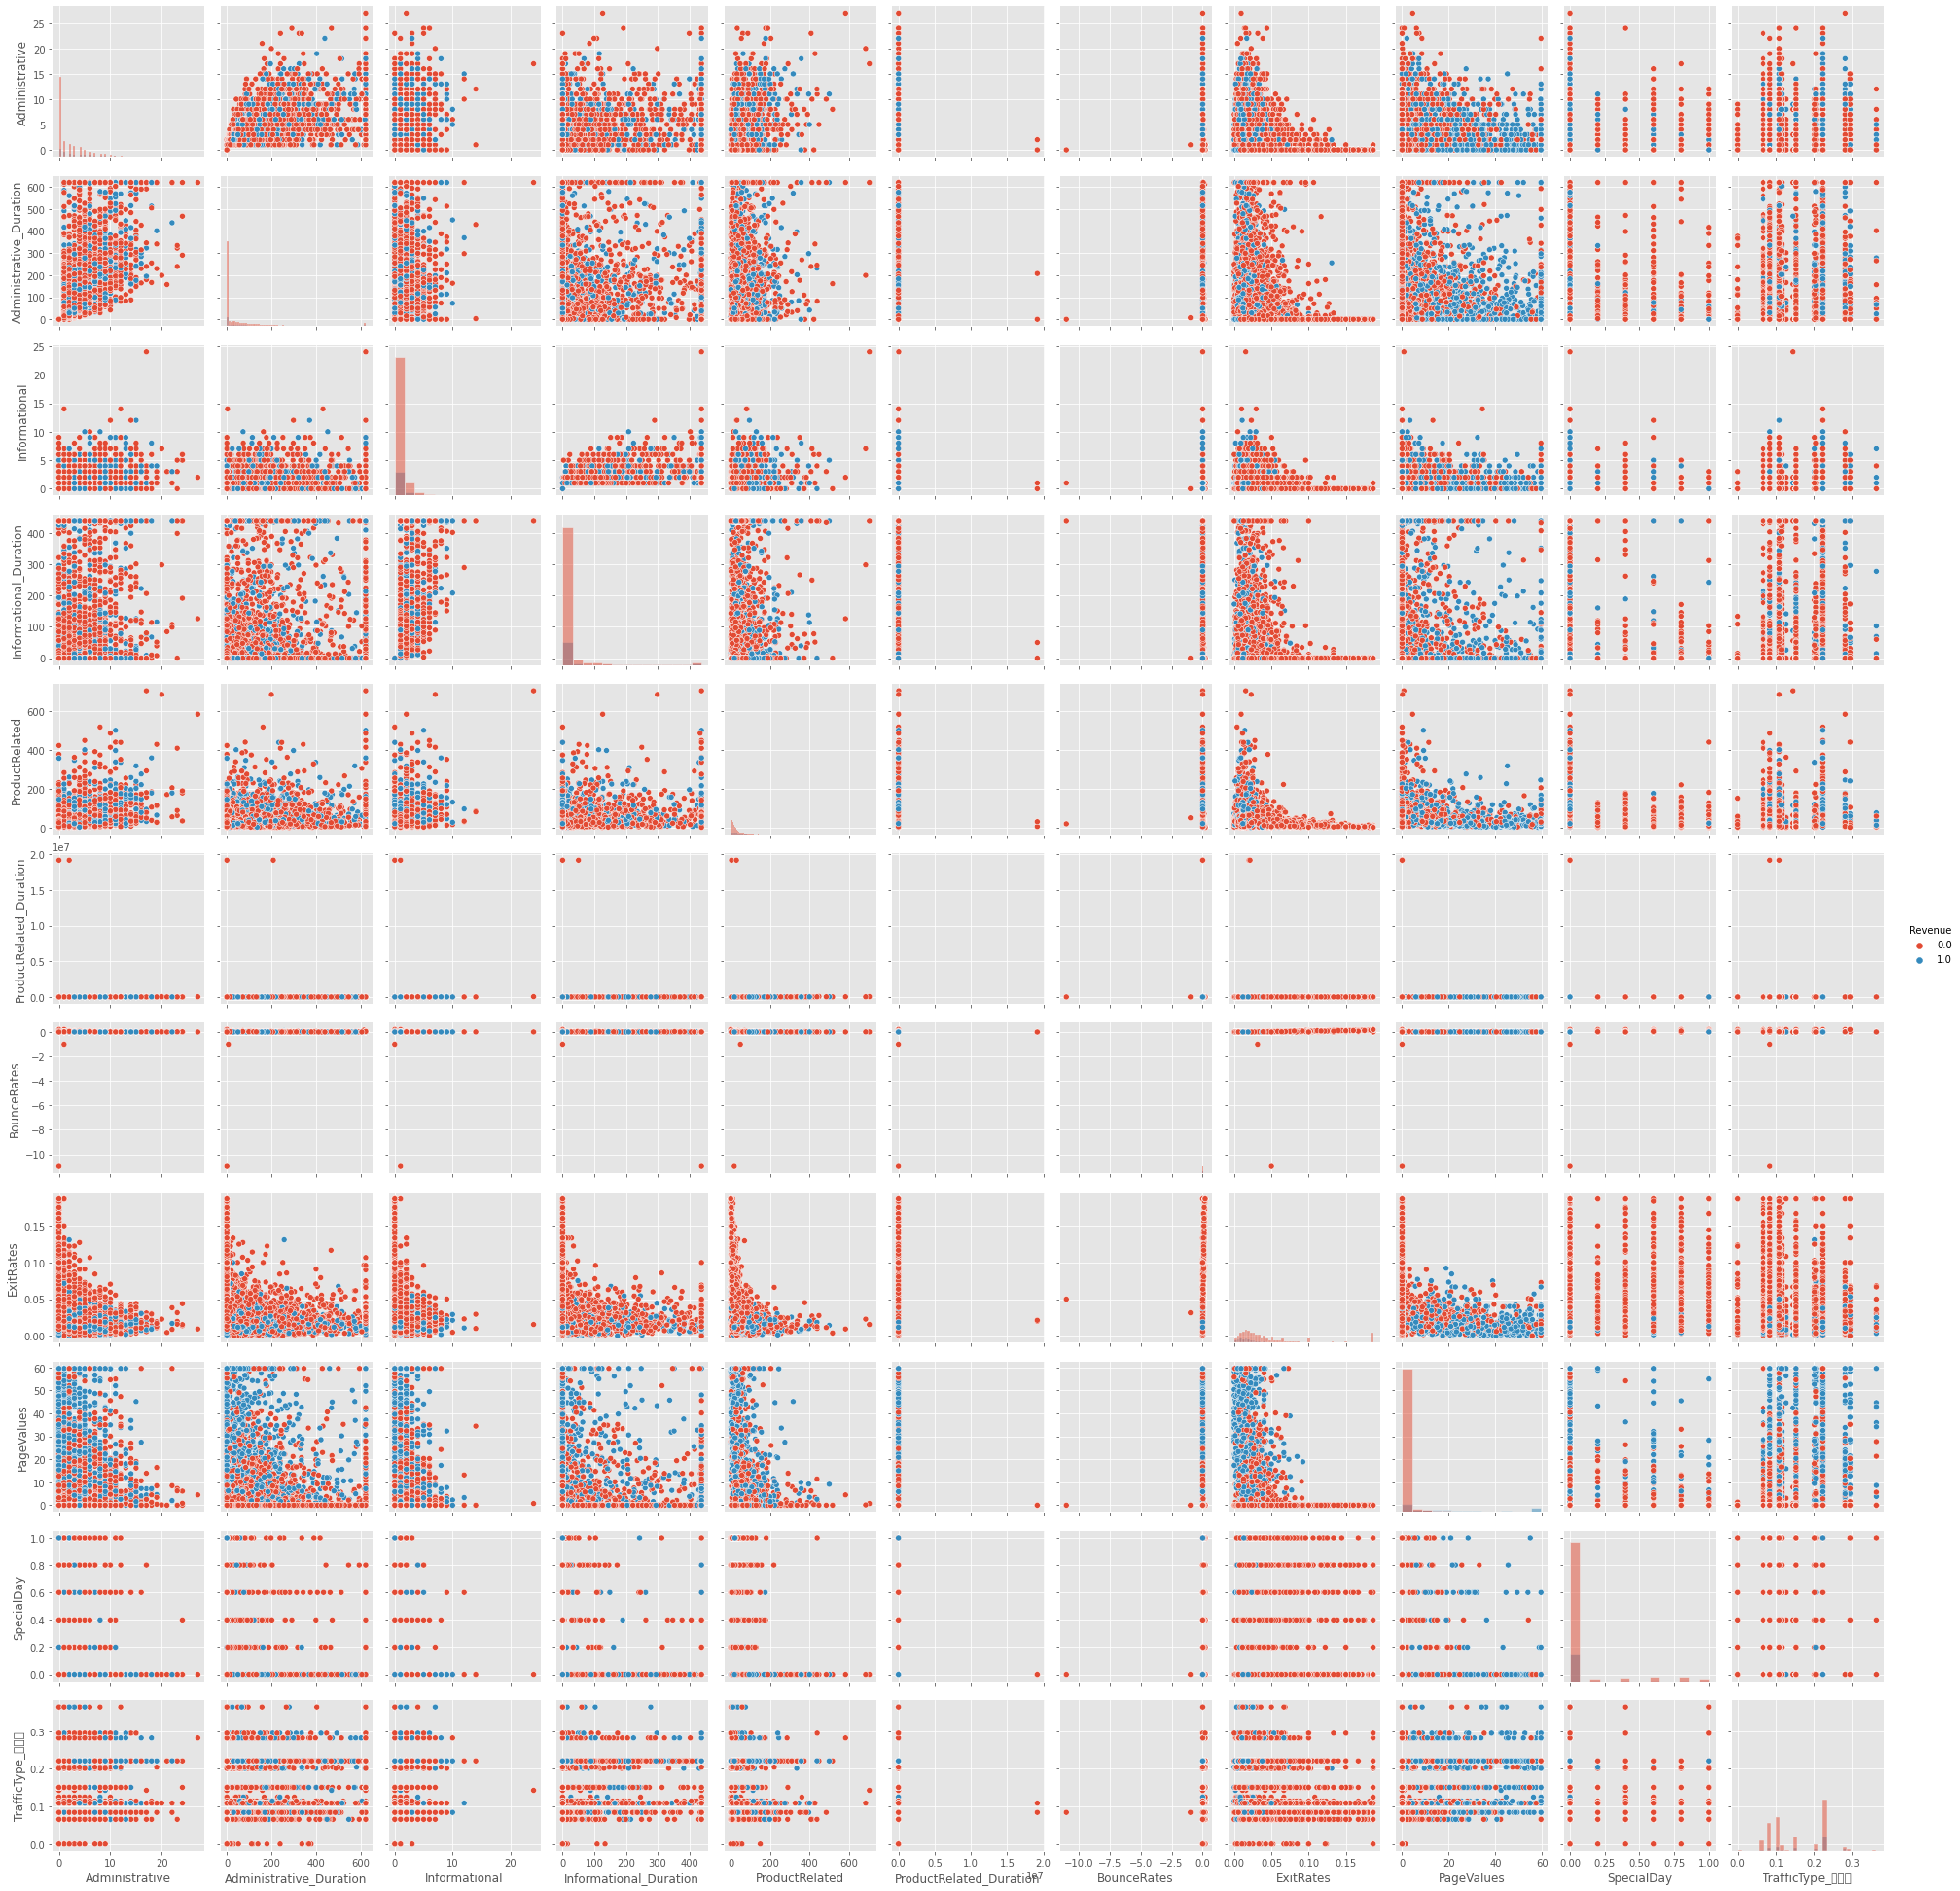

In [13]:
sns.pairplot(df.iloc[:,:12], diag_kind ='hist' , hue="Revenue")#變量之間觀察
plt.show()
#Analyse:

### 1.3.3相關性分析

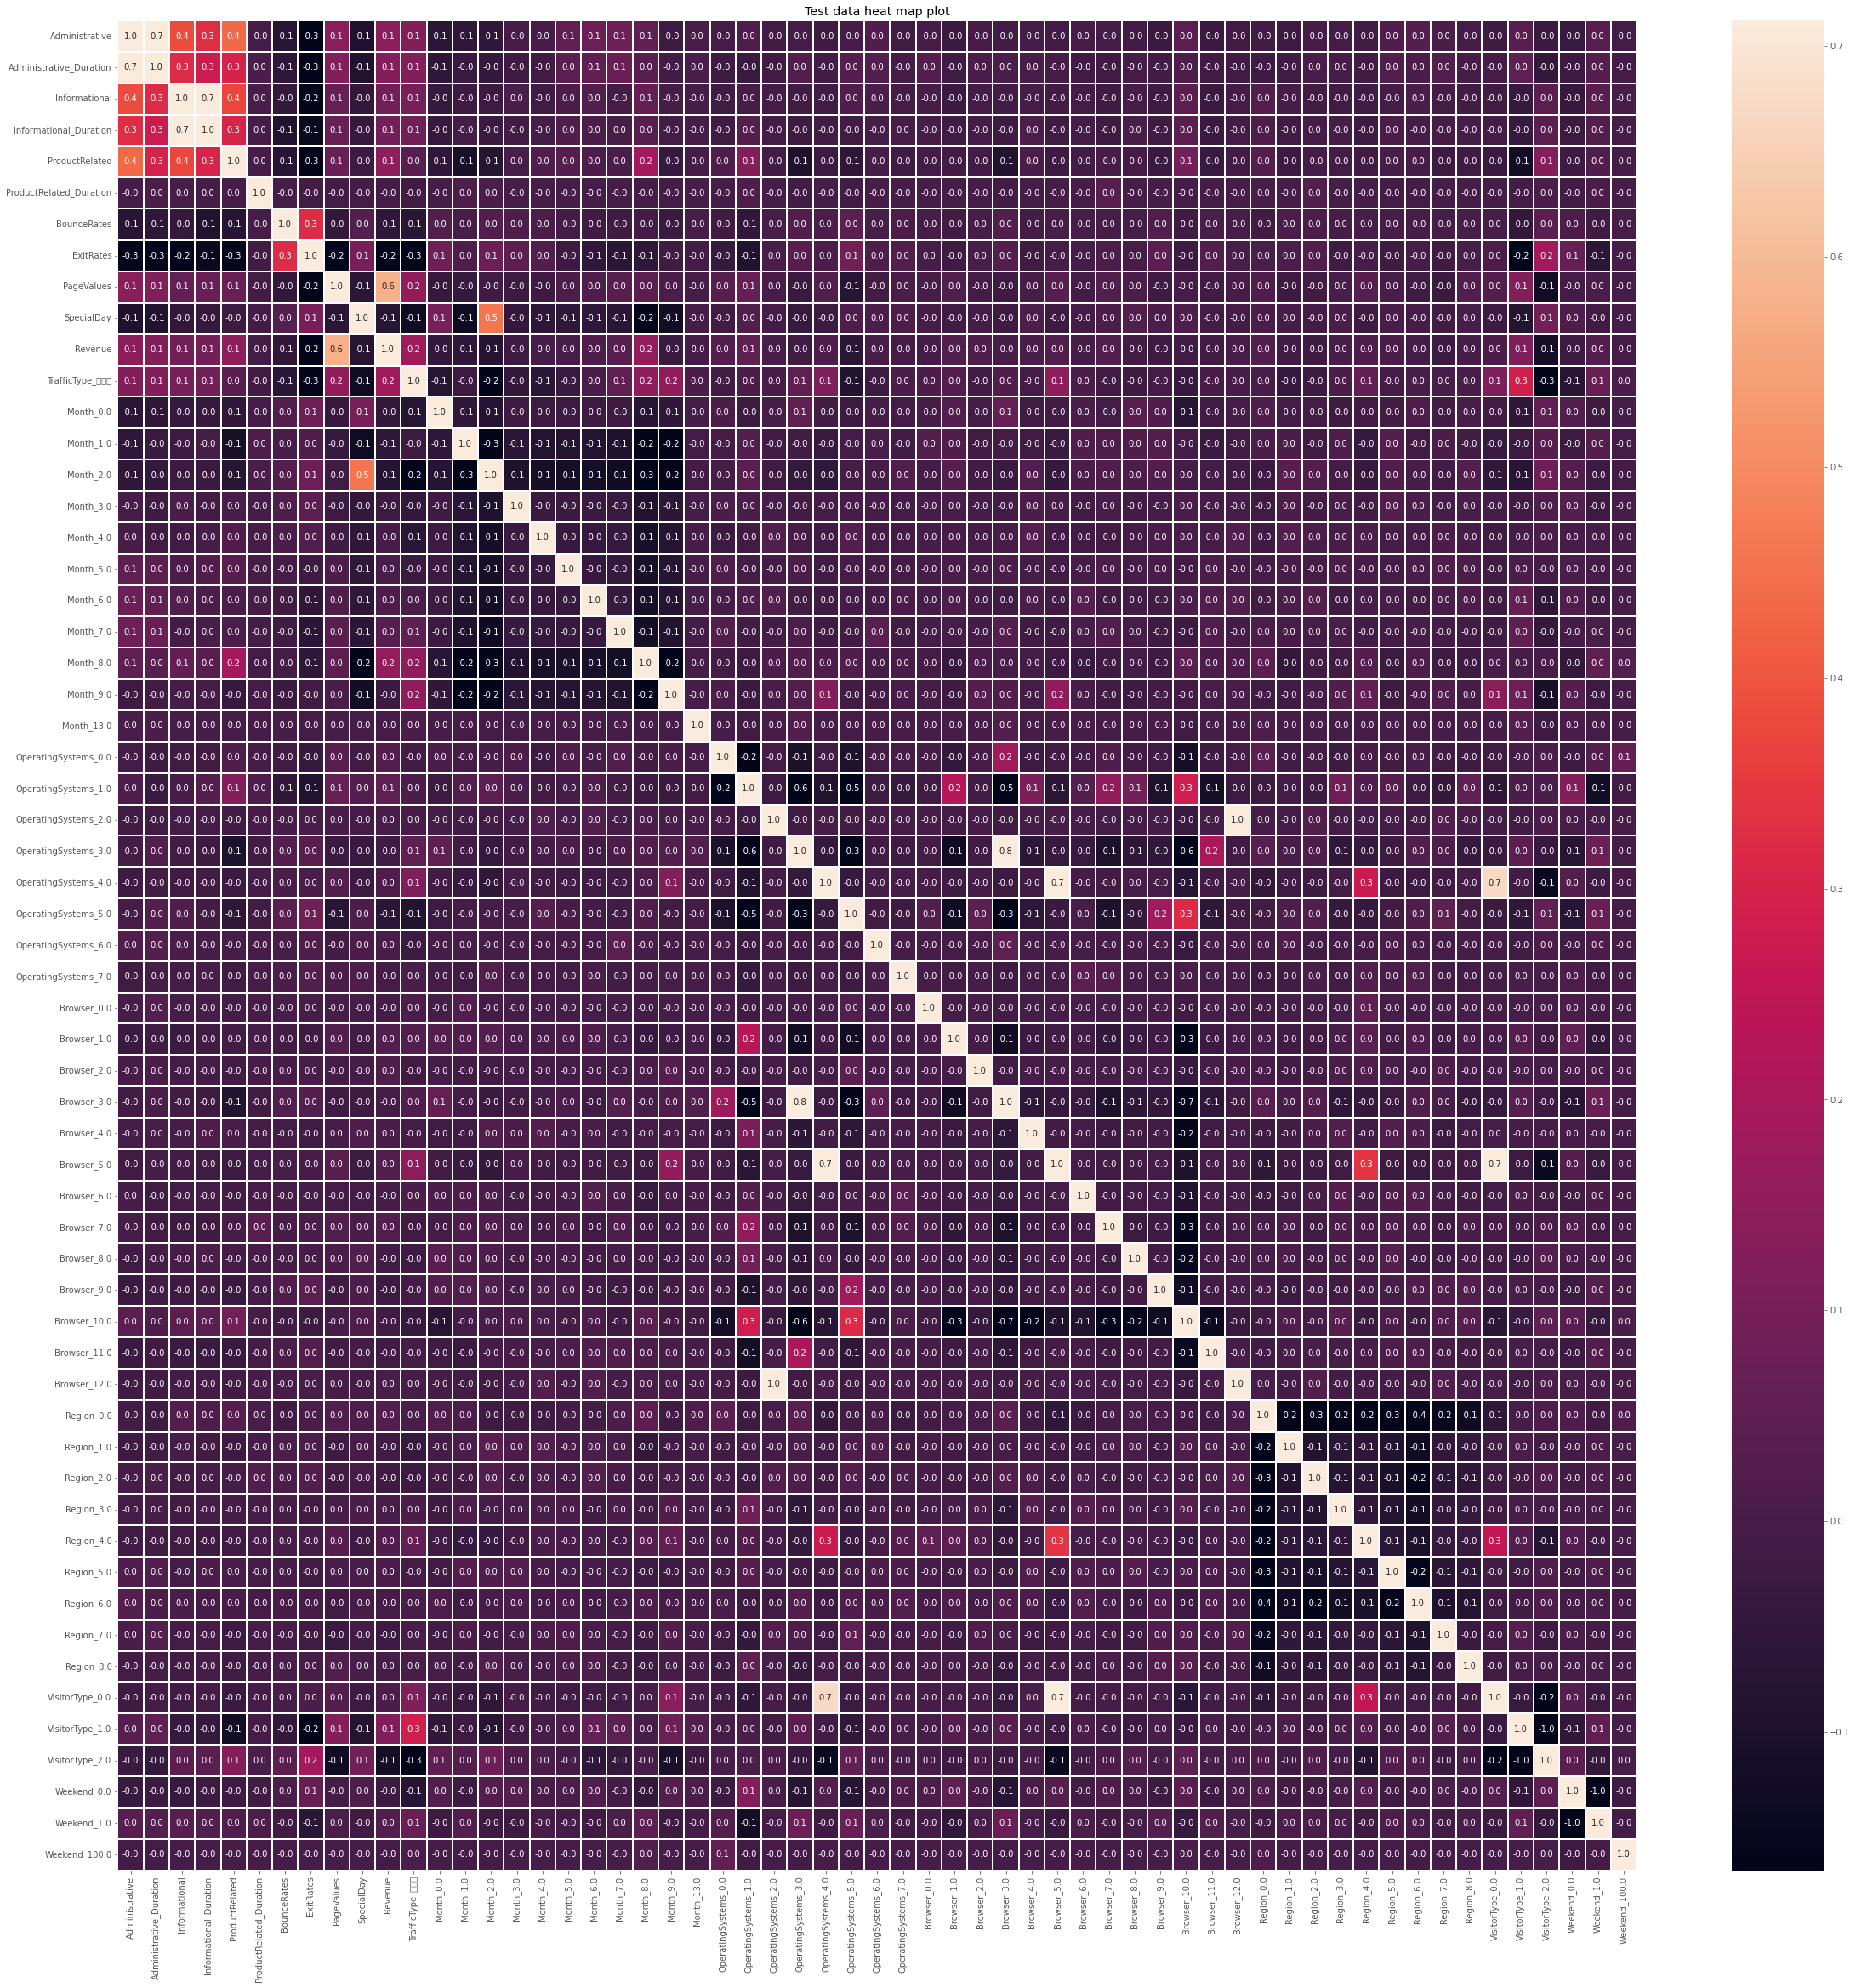

In [14]:
f,ax = plt.subplots(figsize=(40, 40))
sns.heatmap(df.corr(), robust=True, annot=True, linewidths=.2, fmt= '.1f',ax=ax)
plt.title('Test data heat map plot');

## 2.平衡資料集

In [15]:
x_train = df.copy()
y_train = x_train.pop('Revenue')
y_train = pd.DataFrame(y_train)

In [16]:

from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
print("Before OverSampling, counts of label '1': {}".format(sum(y_train['Revenue']==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train['Revenue']==0)))

#initialising oversampling
smote= SMOTETomek(0.75,random_state=42)

#implementing oversampling to training data
X_train_res, y_train_res= smote.fit_resample(x_train,y_train)
# sm = ADASYN(random_state=2)
# X_train_res, y_train_res = sm.fit_resample(x_train, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res['Revenue']==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res['Revenue']==0)))

Before OverSampling, counts of label '1': 1277
Before OverSampling, counts of label '0': 6823 

After OverSampling, the shape of train_X: (11612, 58)
After OverSampling, the shape of train_y: (11612, 1) 

After OverSampling, counts of label '1': 4953
After OverSampling, counts of label '0': 6659


## 3.挑選特徵值：以LGBMClassifier、XGBClassifier、CatBoostClassifier模型進行個別挑選

In [17]:
#以下為挑選特徵值的function
def Search_features(model,X_train_res,y_train_res):
    model_before = model#傳入預輸入模型
    model_before.fit(X_train_res,y_train_res)#進行訓練
    
    #印出特徵重要度
    feat_labels = X_train_res.columns
    importances=model_before.feature_importances_
    indices=np.argsort(importances)[::-1]
    for f in range(X_train_res.shape[1]):
        print("%2d) %-*s %f" % (f+1,30,feat_labels[indices[f]],importances[indices[f]]))
    
    #創立train分數 val分數後續存放用
    train_score = []
    val_score = []

    #依重要度排序，對所有特徵排名都進行訓練集&驗證集預測
    for number in range(X_train_res.shape[-1]-1):
        model_after = model
        important_features = []
        chose_num = number
        for f in range(chose_num+1):
            important_features.append(feat_labels[indices[f]])
        X_train_res_chose_features = X_train_res[important_features]
        X_train_res_chose_features_split, x_test_split, y_train_res_split, y_test_split = train_test_split(X_train_res_chose_features, y_train_res, test_size=0.3, random_state=1)
        model_after.fit(X_train_res_chose_features_split,y_train_res_split)
        #chose_model.score(X_train_res_chose_features_split, y_train_res_split), chose_model.score(x_test_split , y_test_split)
        train_score.append(model_after.score(X_train_res_chose_features_split, y_train_res_split))
        val_score.append(model_after.score(x_test_split , y_test_split))

    #畫出訓練%驗證過程中的數量分數圖
    epochs=range(len(train_score))
    plt.figure()
    plt.plot(epochs,train_score,'b',label='Training score')
    plt.plot(epochs,val_score,'r',label='Validation score')
    plt.title('Traing and Validation score')
    plt.legend()
    plt.show()
    print('train_score_test:' + str(train_score))
    print('val_score_test:' + str(val_score))
    return train_score,val_score
    

 1) ExitRates                      323.000000
 2) PageValues                     276.000000
 3) ProductRelated_Duration        270.000000
 4) ProductRelated                 234.000000
 5) Administrative_Duration        210.000000
 6) BounceRates                    203.000000
 7) Administrative                 193.000000
 8) TrafficType_訂房率                178.000000
 9) Informational_Duration         72.000000
10) Month_2.0                      69.000000
11) Informational                  63.000000
12) Month_1.0                      53.000000
13) Month_9.0                      50.000000
14) VisitorType_2.0                45.000000
15) OperatingSystems_1.0           42.000000
16) Region_0.0                     42.000000
17) Region_6.0                     41.000000
18) OperatingSystems_3.0           39.000000
19) Browser_10.0                   38.000000
20) VisitorType_1.0                34.000000
21) OperatingSystems_5.0           33.000000
22) Month_8.0                      32.000000
23

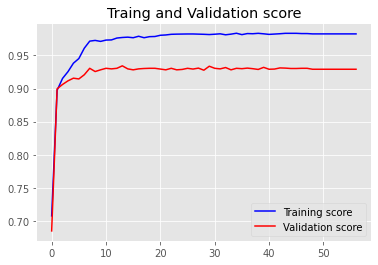

train_score_test:[0.7075541338582677, 0.8972687007874016, 0.9152312992125984, 0.9254429133858267, 0.938238188976378, 0.9452509842519685, 0.9608759842519685, 0.9715797244094488, 0.9726870078740157, 0.9712106299212598, 0.9731791338582677, 0.9734251968503937, 0.9762549212598425, 0.9771161417322834, 0.9776082677165354, 0.9767470472440944, 0.9789616141732284, 0.9767470472440944, 0.9783464566929134, 0.9785925196850394, 0.9804379921259843, 0.9809301181102362, 0.9819143700787402, 0.9821604330708661, 0.9822834645669292, 0.9824064960629921, 0.9824064960629921, 0.9821604330708661, 0.9819143700787402, 0.9815452755905512, 0.9820374015748031, 0.9826525590551181, 0.9811761811023622, 0.9821604330708661, 0.983513779527559, 0.9814222440944882, 0.9830216535433071, 0.9827755905511811, 0.9833907480314961, 0.9826525590551181, 0.9817913385826772, 0.9822834645669292, 0.9827755905511811, 0.9833907480314961, 0.9833907480314961, 0.9833907480314961, 0.9830216535433071, 0.9830216535433071, 0.9825295275590551, 0.98

In [18]:
#找出LGBMClassifier最適特徵
lgb_model = lgb.LGBMClassifier(random_state=42)
lgbm_train_accuracy, lgbm_val_accuracy = Search_features(lgb_model,X_train_res,y_train_res)

 1) PageValues                     0.149616
 2) VisitorType_2.0                0.077966
 3) Month_2.0                      0.048011
 4) VisitorType_1.0                0.039877
 5) VisitorType_0.0                0.036107
 6) Weekend_1.0                    0.032922
 7) Month_1.0                      0.030567
 8) Month_9.0                      0.030367
 9) OperatingSystems_5.0           0.028109
10) Browser_4.0                    0.027980
11) Weekend_0.0                    0.025636
12) Browser_7.0                    0.025543
13) Month_6.0                      0.024908
14) OperatingSystems_0.0           0.024334
15) Month_5.0                      0.023547
16) Region_6.0                     0.020967
17) OperatingSystems_3.0           0.020527
18) Browser_11.0                   0.018834
19) Region_3.0                     0.018052
20) TrafficType_訂房率                0.017681
21) Month_8.0                      0.017001
22) Region_5.0                     0.016739
23) Region_1.0                  

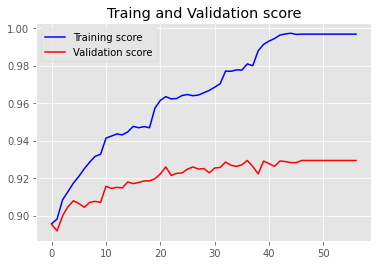

train_score_test:[0.8956692913385826, 0.8981299212598425, 0.9083415354330708, 0.9127706692913385, 0.9173228346456693, 0.9208907480314961, 0.9249507874015748, 0.9285187007874016, 0.9315944881889764, 0.9327017716535433, 0.9413139763779528, 0.9424212598425197, 0.9435285433070866, 0.9430364173228346, 0.9446358267716536, 0.9475885826771654, 0.9468503937007874, 0.9474655511811023, 0.9468503937007874, 0.9573080708661418, 0.9614911417322834, 0.9634596456692913, 0.9622293307086615, 0.9624753937007874, 0.9640748031496063, 0.9645669291338582, 0.9639517716535433, 0.9643208661417323, 0.9655511811023622, 0.9667814960629921, 0.968503937007874, 0.9703494094488189, 0.9771161417322834, 0.9769931102362205, 0.9777312992125984, 0.9776082677165354, 0.9809301181102362, 0.9799458661417323, 0.9879429133858267, 0.9913877952755905, 0.9931102362204725, 0.9944635826771654, 0.9963090551181102, 0.9969242125984252, 0.9972933070866141, 0.9966781496062992, 0.9968011811023622, 0.9968011811023622, 0.9968011811023622, 0.9

In [19]:
#找出XGBClassifier最適特徵
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_train_accuracy, xgb_val_accuracy = Search_features(xgb_model,X_train_res,y_train_res)

 1) PageValues                     19.109518
 2) Month_2.0                      11.971676
 3) Weekend_0.0                    7.814028
 4) Month_1.0                      6.558722
 5) VisitorType_2.0                5.086007
 6) Weekend_1.0                    4.686552
 7) TrafficType_訂房率                4.633842
 8) ExitRates                      3.224847
 9) Administrative                 3.032820
10) Informational                  3.000275
11) ProductRelated_Duration        2.900592
12) ProductRelated                 2.820873
13) OperatingSystems_1.0           2.813228
14) BounceRates                    2.188215
15) Administrative_Duration        1.845860
16) Month_9.0                      1.737713
17) OperatingSystems_3.0           1.697225
18) VisitorType_1.0                1.628436
19) OperatingSystems_5.0           1.476507
20) Browser_10.0                   1.375929
21) Region_0.0                     1.291928
22) Browser_3.0                    1.056522
23) Region_6.0                

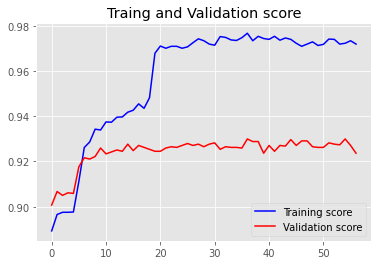

train_score_test:[0.8892716535433071, 0.8965305118110236, 0.8975147637795275, 0.8975147637795275, 0.8976377952755905, 0.9111712598425197, 0.9261811023622047, 0.9286417322834646, 0.9343011811023622, 0.9339320866141733, 0.9375, 0.937376968503937, 0.9395915354330708, 0.9397145669291339, 0.9418061023622047, 0.9426673228346457, 0.9454970472440944, 0.9435285433070866, 0.9482037401574803, 0.967888779527559, 0.9710875984251969, 0.9701033464566929, 0.9709645669291339, 0.9709645669291339, 0.9701033464566929, 0.9707185039370079, 0.9725639763779528, 0.9742864173228346, 0.9734251968503937, 0.9719488188976378, 0.9714566929133859, 0.9752706692913385, 0.9749015748031497, 0.9737942913385826, 0.9735482283464567, 0.9747785433070866, 0.9767470472440944, 0.9734251968503937, 0.9753937007874016, 0.9744094488188977, 0.9740403543307087, 0.9753937007874016, 0.9736712598425197, 0.9746555118110236, 0.9740403543307087, 0.9723179133858267, 0.9709645669291339, 0.9719488188976378, 0.9729330708661418, 0.97133366141732

In [20]:
#找出CatBoostClassifier最適特徵
cat_model = CatBoostClassifier(iterations=100,random_state=42, verbose=False)
cat_train_accuracy, cat_val_accuracy = Search_features(cat_model,X_train_res,y_train_res)

### 將訓練集分數以及驗證集分數平均，取accuracy最高時的特徵數量

In [21]:
#將以上三種訓練集驗證分數輸出裝成dataframe，進行最適特徵挑選
total_score_data = pd.DataFrame([lgbm_train_accuracy, lgbm_val_accuracy, xgb_train_accuracy, xgb_val_accuracy, cat_train_accuracy,cat_val_accuracy])
total_score_data = total_score_data.T
total_score_data.columns = ['lgb_train_accuracy','lgb_val_accuracy','xgb_train_accuracy','xgb_val_accuracy','cat_train_accuracy',
'cat_val_accuracy']
print('lgb_best:' + str(((total_score_data['lgb_train_accuracy'] + total_score_data['lgb_val_accuracy'])/2).idxmax()))
print('xgb_best:' + str(((total_score_data['xgb_train_accuracy'] + total_score_data['xgb_val_accuracy'])/2).idxmax()))
print('cat_best:' + str(((total_score_data['cat_train_accuracy'] + total_score_data['cat_val_accuracy'])/2).idxmax()))

lgb_best:29
xgb_best:46
cat_best:36


## 4.使用KFOLD = 3 對模型進行訓練&驗證

In [22]:

def run_cv_model(x_train, y_train, model, chose_num, model_name='model', n_folds=3, test=None):
    #x_train:訓練資料
    #y_train:訓練資料答案
    #model:測試模型
    #chose_num:挑選特徵數量
    #model_name:模型名稱
    #n_folds:k折
    #test:有無測試資料

    #設定Kfold
    n_folds = n_folds
    kf = KFold(n_splits=n_folds,random_state = 10,shuffle=True)
    #挑選特徵數量
    model_before = model
    model_before.fit(x_train,y_train)
    feat_labels = x_train.columns
    importances=model_before.feature_importances_
    indices=np.argsort(importances)[::-1]
    important_features = []
    for f in range(chose_num+1):
        important_features.append(feat_labels[indices[f]])
    X_train_important_features = x_train[important_features]
    #切分訓練資料
    fold_splits = kf.split(X_train_important_features, y_train)
    #以字典方式裝accuracy
    fold_answer = {}
    true_answer = {}
    test_answer = {}

    for count,(dev_index, val_index) in enumerate(fold_splits):#進行kfold
        print('-------------------------------------------')
        print('Started fold ' + str(count+1) + f'/{n_folds}')
        dev_X, val_X = X_train_important_features.iloc[dev_index], X_train_important_features.iloc[val_index]
        dev_y, val_y = y_train.iloc[dev_index], y_train.iloc[val_index]
        model_after = model
        model_after.fit(dev_X,dev_y)
        print('eval accuracy:' + str(model_after.score(val_X, val_y)))#印出每一個fold中驗證分數
        pred_ans = model_after.predict(val_X)
        fold_answer['True_fold_' + str(count)] = val_y
        fold_answer[model_name + '_fold_' + str(count)] = pred_ans
        if test is not None:#如果有測試資料，執行此區
            test_important = test[important_features]
            pred_test = model_after.predict(test_important)
            test_answer[model_name + '_fold_' + str(count)] = pred_test
    if test is not None:#如果有測試資料，則回傳train eval test答案
        return fold_answer,test_answer
    else:
        return fold_answer #無測試資料，則回傳train eval




In [23]:
#進行LGBMClassifier模型訓練&驗證
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_answer = run_cv_model(X_train_res, y_train_res, lgb_model, 29, model_name='lgbm', n_folds=3)

-------------------------------------------
Started fold 1/3
eval accuracy:0.9325755618703178
-------------------------------------------
Started fold 2/3
eval accuracy:0.9325755618703178
-------------------------------------------
Started fold 3/3
eval accuracy:0.9304909560723514


In [24]:
#進行XGBClassifier模型訓練&驗證
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_answer = run_cv_model(X_train_res, y_train_res, xgb_model, 46, model_name='xgb', n_folds=3)

-------------------------------------------
Started fold 1/3
eval accuracy:0.9307672436063033
-------------------------------------------
Started fold 2/3
eval accuracy:0.9315422371480238
-------------------------------------------
Started fold 3/3
eval accuracy:0.9304909560723514


In [25]:
#進行CatBoostClassifier模型訓練&驗證
cat_model = CatBoostClassifier(random_state=40,verbose=False)
cat_answer = run_cv_model(X_train_res, y_train_res, cat_model, 36, model_name='cat', n_folds=3)

-------------------------------------------
Started fold 1/3
eval accuracy:0.9320588995091708
-------------------------------------------
Started fold 2/3
eval accuracy:0.9323172306897443
-------------------------------------------
Started fold 3/3
eval accuracy:0.9330749354005168


## 5.多數決投票：使用多數決投票方法對每一個fold進行投票，提高accuracy

### 5.1 將第四步驟輸出的lgb、xgb、cat模型在fold = 0 的驗證集進行投票
#### fold=0，投票後效果提升至0.93335，與單個模型預測最差fold = 0 增加了0.003

In [26]:
fold_1_preds = pd.DataFrame([lgb_answer['lgbm_fold_0'],xgb_answer['xgb_fold_0'],cat_answer['cat_fold_0']]).T
for i in fold_1_preds.index:
  voting = collections.Counter(fold_1_preds.loc[i]).most_common(1)[0][0]
  fold_1_preds.loc[i,'label'] = int(voting)
fold_1_preds['True_fold_0'] = lgb_answer['True_fold_0'].reset_index(drop = True)
print('accuracy:',metrics.accuracy_score(fold_1_preds['True_fold_0'], fold_1_preds['label']))
print('Precision:', metrics.precision_score(fold_1_preds['True_fold_0'], fold_1_preds['label']))
print('Recall:', metrics.recall_score(fold_1_preds['True_fold_0'], fold_1_preds['label']))
print('F1:', metrics.f1_score(fold_1_preds['True_fold_0'], fold_1_preds['label']))

accuracy: 0.9338672177731853
Precision: 0.9312461632903621
Recall: 0.9133052378085491
F1: 0.9221884498480243


### 5.2 將第四步驟輸出的lgb、xgb、cat模型在fold = 1 的驗證集進行投票
#### fold=1，投票後效果提升至0.93335，與單個模型預測最差fold = 1 增加了0.002

In [27]:
fold_1_preds = pd.DataFrame([lgb_answer['lgbm_fold_1'],xgb_answer['xgb_fold_1'],cat_answer['cat_fold_1']]).T
for i in fold_1_preds.index:
  voting = collections.Counter(fold_1_preds.loc[i]).most_common(1)[0][0]
  fold_1_preds.loc[i,'label'] = int(voting)
fold_1_preds['True_fold_1'] = lgb_answer['True_fold_1'].reset_index(drop = True)
print('accuracy:',metrics.accuracy_score(fold_1_preds['True_fold_1'], fold_1_preds['label']))
print('Precision:', metrics.precision_score(fold_1_preds['True_fold_1'], fold_1_preds['label']))
print('Recall:', metrics.recall_score(fold_1_preds['True_fold_1'], fold_1_preds['label']))
print('F1:', metrics.f1_score(fold_1_preds['True_fold_1'], fold_1_preds['label']))

accuracy: 0.9338672177731853
Precision: 0.9160214413341274
Recall: 0.9304295220810648
F1: 0.9231692677070829


### 5.3 將第四步驟輸出的lgb、xgb、cat模型在fold = 2 的驗證集進行投票
#### fold=2，投票後效果提升至0.93335，與單個模型預測最差fold = 2 增加了0.003

In [28]:
fold_2_preds = pd.DataFrame([lgb_answer['lgbm_fold_2'],xgb_answer['xgb_fold_2'],cat_answer['cat_fold_2']]).T
for i in fold_2_preds.index:
  voting = collections.Counter(fold_2_preds.loc[i]).most_common(1)[0][0]
  fold_2_preds.loc[i,'label'] = int(voting)
fold_2_preds['True_fold_2'] = lgb_answer['True_fold_2'].reset_index(drop = True)
print('accuracy:',metrics.accuracy_score(fold_2_preds['True_fold_2'], fold_2_preds['label']))
print('Precision:', metrics.precision_score(fold_2_preds['True_fold_2'], fold_2_preds['label']))
print('Recall:', metrics.recall_score(fold_2_preds['True_fold_2'], fold_2_preds['label']))
print('F1:', metrics.f1_score(fold_2_preds['True_fold_2'], fold_2_preds['label']))

accuracy: 0.9333333333333333
Precision: 0.9259716224552745
Recall: 0.9158023184868822
F1: 0.9208588957055214


## 6.測試集預測

### 6.1測試集資料清洗

In [29]:
#轉換訂房率
yes_booking['TrafficType'] = yes_booking['TrafficType'].astype('float')
for i in yes_booking['TrafficType']:
    test_index = test[test['TrafficType'] == i].index
    test.loc[test_index,'TrafficType_訂房率'] = yes_booking[yes_booking['TrafficType'] == i]['Percent'].values[0]
test = test.drop(columns=['TrafficType'])


In [30]:
#one hot encoding
one_hot_columns = ['Month',
       'OperatingSystems', 'Browser', 'Region',  'VisitorType',
       'Weekend']
for i,j in enumerate(one_hot_columns):
       y = pd.get_dummies(test[j], prefix=one_hot_columns[i])
       test = pd.concat([test,y],axis = 1)
       test = test.drop(columns = one_hot_columns[i])


In [31]:
#one hot encoding後可能還有些類別是test未出現，train有出現，因要統一特徵值，所以須將缺少的特徵補上
for i in X_train_res.columns:
    if i not in test.columns:
        print(i)
        test[i] = 0

Month_13.0
OperatingSystems_2.0
Browser_0.0
Browser_2.0
Browser_12.0
Weekend_100.0


In [32]:
#修正測試集異常值
for col in Measurement_col:
    outlier_index = test[test[col] > (df_describe[col]['mean'] + 3*df_describe[col]['std'])].index #找出異常值index
    test.loc[outlier_index,col] = df_describe[col]['mean'] + 3*df_describe[col]['std'] #更改異常值數值

In [33]:
#將test欄位順序更改為跟train資料一樣
test = test[X_train_res.columns]

In [34]:
#確認未有空值
test.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
TrafficType_訂房率            0
Month_0.0                  0
Month_1.0                  0
Month_2.0                  0
Month_3.0                  0
Month_4.0                  0
Month_5.0                  0
Month_6.0                  0
Month_7.0                  0
Month_8.0                  0
Month_9.0                  0
Month_13.0                 0
OperatingSystems_0.0       0
OperatingSystems_1.0       0
OperatingSystems_2.0       0
OperatingSystems_3.0       0
OperatingSystems_4.0       0
OperatingSystems_5.0       0
OperatingSystems_6.0       0
OperatingSystems_7.0       0
Browser_0.0                0
Browser_1.0                0
Browser_2.0                0
Browser_3.0                0
Browser_4.0   

In [35]:
#載入測試模型進行預測
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_answer,lgb_test_answer = run_cv_model(X_train_res, y_train_res, lgb_model, 40, model_name='lgbm', n_folds=3, test = test)
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_answer,xgb_test_answer = run_cv_model(X_train_res, y_train_res, xgb_model, 40, model_name='xgb', n_folds=3, test = test)
cat_model = CatBoostClassifier(random_state=42,verbose=False)
cat_answer,cat_test_answer = run_cv_model(X_train_res, y_train_res, cat_model, 40, model_name='cat', n_folds=3, test = test)

-------------------------------------------
Started fold 1/3
eval accuracy:0.9336088865926118
-------------------------------------------
Started fold 2/3
eval accuracy:0.9330922242314648
-------------------------------------------
Started fold 3/3
eval accuracy:0.9359173126614987
-------------------------------------------
Started fold 1/3
eval accuracy:0.9268922758977008
-------------------------------------------
Started fold 2/3
eval accuracy:0.9330922242314648
-------------------------------------------
Started fold 3/3
eval accuracy:0.9289405684754521
-------------------------------------------
Started fold 1/3
eval accuracy:0.9315422371480238
-------------------------------------------
Started fold 2/3
eval accuracy:0.9318005683285973
-------------------------------------------
Started fold 3/3
eval accuracy:0.9343669250645995


In [36]:
#預測資料彙整
lgb_test_answer.update(xgb_test_answer)
lgb_test_answer.update(cat_test_answer)
total_answer = pd.DataFrame(lgb_test_answer).astype('int64')
total_answer

,lgbm_fold_0,lgbm_fold_1,lgbm_fold_2,xgb_fold_0,xgb_fold_1,xgb_fold_2,cat_fold_0,cat_fold_1,cat_fold_2
0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
895,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0
898,0,0,0,0,0,0,0,0,0


In [37]:
#預測結果投票產生最終結果
for i in total_answer.index:
  voting = collections.Counter(total_answer.loc[i]).most_common(1)[0][0]
  total_answer.loc[i,'voting'] = voting
total_answer = total_answer.astype('int64')
total_answer

,lgbm_fold_0,lgbm_fold_1,lgbm_fold_2,xgb_fold_0,xgb_fold_1,xgb_fold_2,cat_fold_0,cat_fold_1,cat_fold_2,voting
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
895,0,0,0,0,0,0,0,0,0,0
896,0,0,0,0,0,0,0,0,0,0
897,0,0,0,0,0,0,0,0,0,0
898,0,0,0,0,0,0,0,0,0,0


In [38]:
#輸出結果
test['HasRevenue'] = list(total_answer['voting'])
test[['HasRevenue']].to_csv('output.csv')